## Задание: 
Определить, в каком VK сообществе "Подслушано..." в этом 2022 году больше
всего любят котов.

Базовая метрика любви к котам = доля постов с котами * среднее количество
комментариев / количество подписчиков

# Для нейросети

## Подгрузим необходимое

In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip install wandb
!pip install pytorch-lightning

import torch

from torch.utils.data import DataLoader, random_split

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import f1_score
from numpy import argmax, array
from scipy.io import loadmat

import numpy as np
import os

import wandb

In [ ]:
# !wandb login

In [ ]:
# wandb.init(project="cats-vs-other", entity="c-nemo")

In [ ]:
from torch.utils.data import Dataset

## Константы

In [ ]:
VAL_SIZE = 0.1

BATCH_SIZE = 256
EPOCHS = 1

RESCALE_SIZE = 224
DATA_MODES = ['train', 'val', 'test']

LABELS_LIST = ['Cat','Other']

TRANSFORM = {
    
    'train_without_normaliz': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),

    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## Classifier

In [ ]:
class Classifier(pl.LightningModule):
      
    def __init__(self, model):
      
            super().__init__()
            self.model = model
            self.loss_func = nn.CrossEntropyLoss()

            self.accs = {'train': [], 'val': []}
            self.losses = {'train': [], 'val': []}
            self.best_val_acc = 0

    def loss_acc_train_val(self, batch):

            x, y = batch
            pred = self.model(x)
            
            loss = self.loss_func(pred, y)
            _, pred = torch.max(pred.data, 1)
            
            accuracy =  f1_score(
                                y.detach().cpu().numpy(),
                                pred.detach().cpu().numpy(),
                                average='macro')
            
            return loss, accuracy

    def loss_acc_test(self, batch):

            x, y = batch
            
            pred = self.model(x)
            loss = self.loss_func(pred, y)
            pred = torch.argmax(pred, dim=1)
            accuracy_average = torch.sum(y == pred).item() / (len(y) * 1.0)
            accuracy_f1 =  f1_score(y.detach().cpu().numpy(),
                            pred.detach().cpu().numpy(),
                            average='macro')
            
            return loss, accuracy_average, accuracy_f1

    def training_step(self, batch, batch_idx):
            
            loss, accuracy = self.loss_acc_train_val(batch)
            
            self.log("train_acc_f1", accuracy,  prog_bar=True, on_step=True, on_epoch=True) # on_step=True, on_epoch=True,
            self.log("train_loss", loss,  prog_bar=True, on_step=True, on_epoch=True)
            
            self.accs['train'].append(accuracy)
            self.losses['train'].append(loss) 
            
            return loss

    def validation_step(self, batch, batch_idx):

            loss, accuracy = self.loss_acc_train_val(batch)
            
            self.log("val_acc_f1", accuracy,  prog_bar=True, on_step=True, on_epoch=True)
            self.log("vall_loss", loss,  prog_bar=True, on_step=True, on_epoch=True) 
            
            self.accs['val'].append(accuracy)
            self.losses['val'].append(loss)

            if accuracy > self.best_val_acc:
                self.save()
                self.best_val_acc = accuracy
            
            return loss

    def test_step(self, batch, batch_idx):

            loss, accuracy_average, accuracy_f1 = self.loss_acc_test(batch)
            
            self.log('test_loss', loss, prog_bar=True)
            self.log('test_accuracy_average', torch.tensor(accuracy_average), prog_bar=True)
            self.log('test_accuracy_f1', torch.tensor(accuracy_f1), prog_bar=True)
            
            output = dict({
                'test_loss': loss,
                'test_acc': torch.tensor(accuracy_average)})
            
            return output

    def configure_optimizers(self, lr=1e-3):
            optimizer = torch.optim.Adam(self.parameters(), lr=lr) # 3
            return optimizer
    
    def save(self, path=None):
            if not path:
                path = "/content/drive/My Drive/модели/CatsOther.pt"
            torch.save(self.model.state_dict(), path)
          
    def load_dict(self, path=None):
            if path:
                pre_trained_path = path
            else:
                pre_trained_path = "/content/drive/My Drive/модели/CatsOther.pt"
            state_dict = torch.load(pre_trained_path)
            self.model.load_state_dict(state_dict)

    def make_graph_acc(self, name=None):
  
            yt = self.accs['train']
            yv = self.accs['val']
            step = len(yt) // (len(yv) - 1)
            
            # print(len(yt), len(yv))
            xt = [i for i in range(1, len(yt) + 1)]
            xv = [i for i in range(1, len(yt) + 1, step)]
            while len(xv) > len(yv):
                xv.pop()

            plot = plt.figure(figsize=(15,10))
            plot = plt.plot(xt, yt, c = "r", label = 'train')
            plot = plt.plot(xv, yv, c = "g", label = 'val')
            plt.xlabel("Batch num")
            plt.ylabel("Acc")
            plt.title("Train vs Val Accuracy")
            plt.legend()
            plt.show()

            if name:
                plt.savefig('/content/drive/My Drive/' + name)

    def predict(self, test_loader):

            with torch.no_grad():
                logits = []
                for inputs in test_loader:
                    # inputs = inputs.cuda()
                    self.model.eval()
                    outputs = self.model(inputs)
                    logits.append(outputs)
            
            probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
            return probs

## Настраиваем обучатор

In [ ]:
def get_trainer(epochs):

    wandb_logger = WandbLogger(project='cats-other', log_model=True)
    monitor = 'val_acc_f1'

    early_stop_callback = EarlyStopping(verbose=False,
                                        monitor=monitor,
                                        patience=5)
    
    checkpoint_callback = ModelCheckpoint(dirpath="/content/drive/My Drive/модели/CatsOtherCheckpoint",
                                          verbose=False,
                                          monitor=monitor,
                                          save_top_k=2)
    
    callbacks = [checkpoint_callback, early_stop_callback]
    profiler = None  # 'simple'/'advanced'/None

    trainer = pl.Trainer(max_epochs=epochs,
                        # profiler=profiler,
                        callbacks=callbacks,
                        logger=wandb_logger,
                        accelerator="gpu")
    
    return trainer

## Вспомогательные функции

In [ ]:
def show_samples(dataset, n):
        figure = plt.figure(figsize=(10, 10))
        cols, rows = n, n
        for i in range(1, cols * rows + 1):

            sample_idx = torch.randint(len(dataset), size=(1,)).item()
            img, label = dataset[sample_idx]

            figure.add_subplot(rows, cols, i)
            try:
                plt.title(LABELS_LIST[label])
            except Exception:
                pass
            plt.axis("off")
            
            plt.imshow(transforms.ToPILImage()(img), cmap="gray")

        plt.show()

# Данные

## Картинки для обучения

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_val_root = '/content/drive/My Drive/datasets/Cats_vs_Other/train'

Mounted at /content/drive


### Для наглядности применим все преобразования, кроме нормализации, к картинкам

In [ ]:
dataset_demo = datasets.ImageFolder(root=train_val_root, transform=TRANSFORM['train_without_normaliz'])

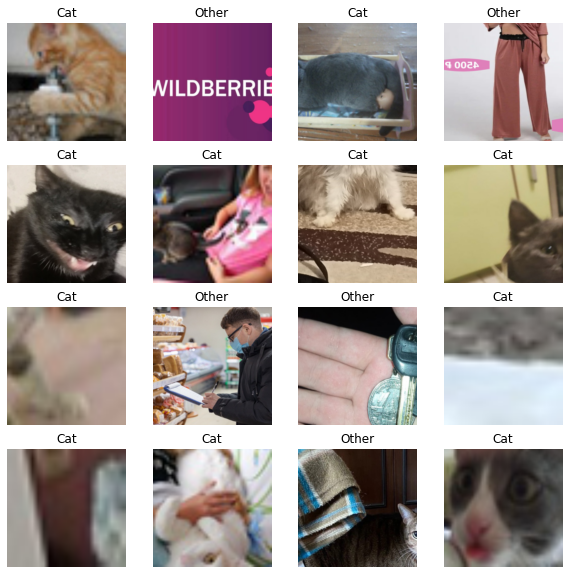

In [ ]:
show_samples(dataset_demo, 4)

### В модель будут подаваться уже нормализованные тензоры

In [ ]:
train_val_dataset = datasets.ImageFolder(root=train_val_root, transform=TRANSFORM['train'])

In [ ]:
len_data = len(train_val_dataset)
val_size = int(VAL_SIZE * len_data)
train_size = len_data - val_size

In [ ]:
len_data

9414

In [ ]:
train_dataset, val_dataset = random_split(train_val_dataset, (train_size, val_size))

In [ ]:
len(train_dataset)

8473

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # bs was 1, why

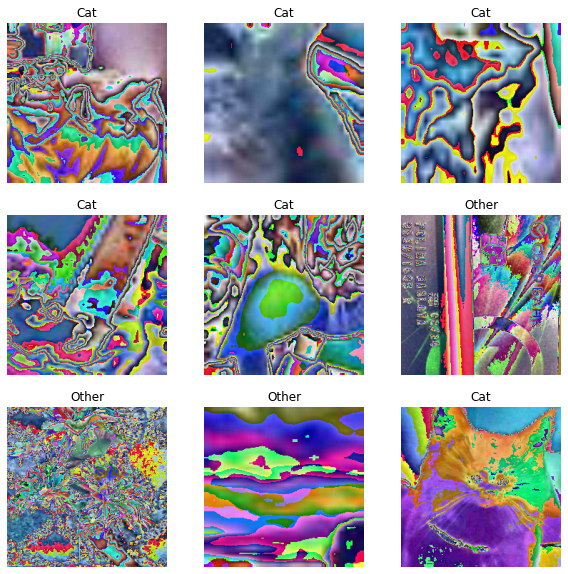

In [ ]:
show_samples(train_dataset, 3)

## Картинки по 50-ти группам

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
test_root = '/content/drive/My Drive/datasets/Cats_vs_Other/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision.io import read_image

In [ ]:
class PredictDataset(Dataset):
    def __init__(self, img_dir, img_labels, length, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.length = length
        self.img_labels = img_labels

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, None

In [ ]:
# name - dataloaders dict
data = dict()
for dirname, _, filenames in os.walk(test_root):
    d = dirname.split('/')[-1]
    l = len(filenames)
    if l == 0:
        continue
    # dataset = dirname # datasets.ImageFolder(root=dirname, transform=TRANSFORM['test'])
    # print(l)
    dataset = PredictDataset(img_dir=dirname, img_labels=filenames, length=l, transform=TRANSFORM['test'])

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    data[d] = dataloader   

In [ ]:
# for dirname, _, filenames in os.walk(test_root):
#     print(dirname)

# Обучение нейросети на классификацию коты / другое

In [ ]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Возьмем модель для котов-собак из предыдущего задания и заменим последний слой.
Заморозив остальные.

In [ ]:
num_ftrs = model_ft.fc.in_features

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.fc = nn.Linear(num_ftrs, 2)

In [ ]:
classifier = Classifier(model_ft)

In [ ]:
trainer = get_trainer(EPOCHS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(classifier, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
classifier.configure_optimizers(lr=1e-4)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [ ]:
trainer = get_trainer(EPOCHS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(classifier, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
sorted(classifier.accs['val'], reverse=True)

[0.8827838827838829,
 0.8783698867380876,
 0.8547926808796373,
 0.8391343663310191,
 0.8355762172742844,
 0.8354453627180899,
 0.8108374384236453,
 0.8098892258184294,
 0.8088397790055248,
 0.7768368617683685,
 0.3486005089058524,
 0.3159360964239013]

In [ ]:
classifier.accs['val']

[0.3486005089058524,
 0.3159360964239013,
 0.8108374384236453,
 0.8098892258184294,
 0.8354453627180899,
 0.8088397790055248,
 0.8391343663310191,
 0.7768368617683685,
 0.8355762172742844,
 0.8783698867380876,
 0.8827838827838829,
 0.8547926808796373]

# График

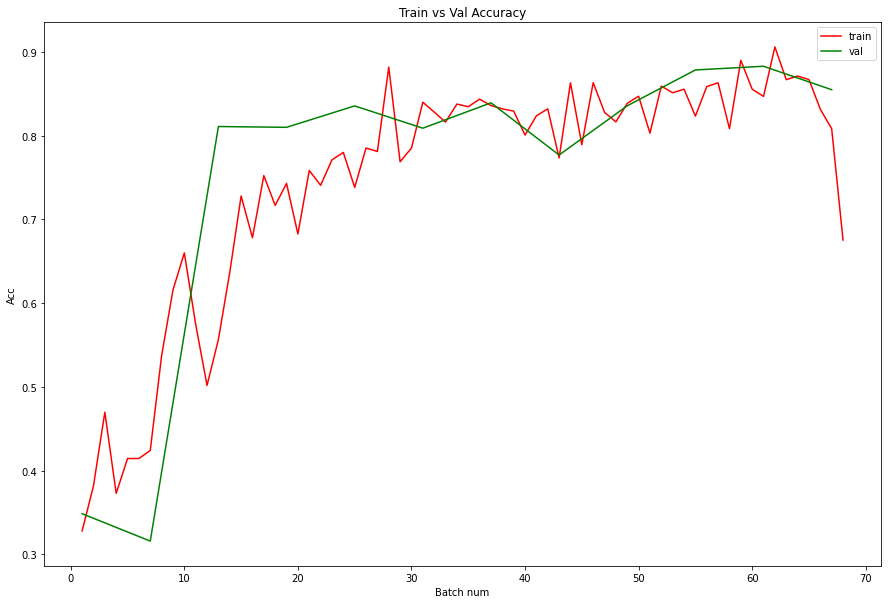

In [ ]:
classifier.make_graph_acc()

In [ ]:
classifier.save()

# Получение предсказаний для каждого из 50-ти датасетов

In [ ]:
model_ft = models.resnet18(pretrained=True)

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

In [ ]:
classifier = Classifier(model_ft)

In [ ]:
classifier.load_dict(_)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
test_root = '/content/drive/My Drive/datasets/Cats_vs_Other/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CSV- файл

In [ ]:
def make_csv():

  import os
  import pandas as pd
  from torchvision.io import read_image
  from PIL import Image
  from torch import Tensor
  from torch.autograd import Variable

  TRANSFORM_TEST = transforms.Compose([
      # transforms.Grayscale(),
      transforms.Resize([224, 224]),
      transforms.ToTensor(),
  ])

  def predict(image):
      image_tensor = TRANSFORM_TEST(image).float()
      image_tensor = image_tensor.unsqueeze_(0)
      input = Variable(image_tensor)
      output = model(input)
      index = output.data.cpu().numpy().argmax()
      return index


  model = classifier.model
  model.eval()

  data = {'Group':  [],
        'All': [],
        'Cats': [],
        'Other': [],
        'Cats/All': []
        }

  path = '/content/drive/My Drive/datasets/Cats_vs_Other/test'

  count = 0
  for dirname, _, filenames in os.walk(path):

      d = dirname.split('/')[-1]
      l = len(filenames)
      if not 10 < l <= 500:
          continue

      print(d, l)

      count += 1
      if count > 5:
          break

      cats = 0
      other = 0

      for file in filenames:
          imgpath = dirname + '/' + file
          image = Image.open(imgpath)
          pred = predict(image)
          if pred == 0:
              cats += 1
          else:
              other += 1

      data['Group'].append(d)
      data['All'].append(l)
      data['Cats'].append(cats)
      data['Other'].append(other)
      data['Cats/All'].append(cats/other)

  df = pd.DataFrame(data)
  df.to_csv(r"/content/drive/MyDrive/CatsOther.csv", index=False, sep=",")
  return df


In [ ]:
csv = make_csv()

overhear_mtu 301
overhear_rguk 129
overheard_in_yaroslavl 257
ysinsk.komi 159
isamovartula 172
angarskr38 79


In [ ]:
csv

,Group,All,Cats,Other,Cats/All
0,overhear_mtu,301,6,295,0.020339
1,overhear_rguk,129,7,122,0.057377
2,overheard_in_yaroslavl,257,4,253,0.015810
3,ysinsk.komi,159,5,154,0.032468
4,isamovartula,172,34,138,0.246377
